In [1]:
from symred.symplectic_form import PauliwordOp
from symred.S3_projection import (S3_projection, 
                                  gf2_gaus_elim, 
                                  gf2_basis_for_gf2_rref, 
                                  QubitTapering, 
                                  CS_VQE, 
                                  CheatS_VQE)
from symred.build_model import build_molecule_for_projection
import json
import numpy as np
import openfermion as of
import openfermionpyscf as ofpyscf
from openfermion.circuits import ( uccsd_singlet_get_packed_amplitudes,
                                   uccsd_singlet_generator, uccsd_generator,
                                   uccsd_convert_amplitude_format)
from itertools import combinations, product

ModuleNotFoundError: No module named 'symred.build_model'

In [2]:
with open('molecule_geometries/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HO

In [3]:
# Set molecule parameters
speciesname = 'H2S_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

delete_input = True
delete_output = True
cisd=1
ccsd=1
fci =1 # wouldn't advise turning this on over 32 qubits!

# Run pyscf.
molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
calculated_molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=cisd,run_ccsd=ccsd,run_fci=fci)

hydrogen sulfide


In [4]:
oh = ordering_heuristics(calculated_molecule)

NameError: name 'ordering_heuristics' is not defined

In [28]:


# Two examples are provided -- comment out as necessary

# One for which Hartree-Fock identifies the correct symmetry sector...
geometry=[
    ("F",(0,0,0)),
    ("H",(0.952519,0,0)),
    #("H",(-0.246530058,0.9200627021,0))
]

# ...and one for which it does not.
#geometry=[
#    ('H', (0.0,0.0,0.0)),
#    ('H', (2.45366053071732,0.0,0.0)),
#    #('H', (2.45366053071732,2.45366053071732,0.0)),
#    #('H', (0.0,2.45366053071732,0.0))
#     ]    
    
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
#molecule.load()

# Run pyscf.
molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=0,run_cisd=0,run_ccsd=0,run_fci=0)

n_qubits    = 2*molecule.n_orbitals
n_electrons = molecule.n_electrons

ham_fermionic = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_jw = of.jordan_wigner(ham_fermionic)

ham_dict = QubitOperator_to_dict(ham_jw, n_qubits)

print('Jordan-Wigner Hamiltonian:\n\n', ham_dict)

Jordan-Wigner Hamiltonian:

 {'IIIIIIIIIIII': (-60.82915378963069+0j), 'ZIIIIIIIIIII': (16.18024198177899+0j), 'YZYIIIIIIIII': (0.16763333337705622+0j), 'XZXIIIIIIIII': (0.16763333337705622+0j), 'YZZZYIIIIIII': (-0.04336072808868714+0j), 'XZZZXIIIIIII': (-0.04336072808868714+0j), 'YZZZZZZZZZYI': (-0.057608998626452565+0j), 'XZZZZZZZZZXI': (-0.057608998626452565+0j), 'IZIIIIIIIIII': (16.18024198177899+0j), 'IYZYIIIIIIII': (0.16763333337705622+0j), 'IXZXIIIIIIII': (0.16763333337705622+0j), 'IYZZZYIIIIII': (-0.04336072808868713+0j), 'IXZZZXIIIIII': (-0.04336072808868713+0j), 'IYZZZZZZZZZY': (-0.05760899862645255+0j), 'IXZZZZZZZZZX': (-0.05760899862645255+0j), 'IIZIIIIIIIII': (2.3358585088834865+0j), 'IIYZYIIIIIII': (0.16083479057347452+0j), 'IIXZXIIIIIII': (0.16083479057347452+0j), 'IIYZZZZZZZYI': (0.27529966307135895+0j), 'IIXZZZZZZZXI': (0.27529966307135895+0j), 'IIIZIIIIIIII': (2.3358585088834856+0j), 'IIIYZYIIIIII': (0.16083479057347452+0j), 'IIIXZXIIIIII': (0.16083479057347452+0j), '

In [3]:
from openfermion import FermionOperator, jordan_wigner
hf_state = np.concatenate([np.ones(n_electrons, dtype=int),np.zeros(n_qubits-n_electrons, dtype=int)])

def sor_data():
        """ Calculate the w(i) function 
        as in https://arxiv.org/pdf/1406.4920.pdf
        """
        w = {i:0 for i in range(n_qubits)}
        for f_op,coeff in ham_fermionic.terms.items():
            if len(f_op)==2:
                (p,p_ex),(q,q_ex) = f_op
                # self-interaction terms p==q
                if p==q:
                    w[p] += coeff
            if len(f_op)==4:
                (p,p_ex),(q,q_ex),(r,r_ex),(s,s_ex) = f_op
                #want p==r and q==s for hopping
                if p==r:
                    if q==s and hf_state[q]==1:
                        w[p]+=coeff
        return w
    
def second_order_response():
        """ Calculate the I_a Hamiltonian term importance metric 
        as in https://arxiv.org/pdf/1406.4920.pdf
        """
        w = sor_data()
        f_out = FermionOperator()
        for H_a,coeff in ham_fermionic.terms.items():
            if len(H_a)==4:
                (p,p_ex),(q,q_ex),(r,r_ex),(s,s_ex) = H_a
                Delta_pqrs = abs(w[p]+w[q]-w[r]-w[s])
                if Delta_pqrs == 0:
                    I_a = 1e15
                else:
                    I_a = (abs(coeff)**2)/Delta_pqrs
                
                f_out += FermionOperator(H_a, I_a)
        f_out_jw = jordan_wigner(f_out)
        f_out_q = QubitOperator_to_dict(f_out_jw, n_qubits)
        return f_out_q
    
sor_ham = PauliwordOp({op:coeff for op, coeff in second_order_response().items() if op in ham_dict})
sor_ham.coeff_vec/=np.max(sor_ham.coeff_vec)

In [4]:
mol_op = PauliwordOp(ham_dict)

In [5]:
import scipy

def get_ground_state(sparse_operator, initial_guess=None):
    """Compute lowest eigenvalue and eigenstate.
    Args:
        sparse_operator (LinearOperator): Operator to find the ground state of.
        initial_guess (ndarray): Initial guess for ground state.  A good
            guess dramatically reduces the cost required to converge.
    Returns
    -------
        eigenvalue:
            The lowest eigenvalue, a float.
        eigenstate:
            The lowest eigenstate in scipy.sparse csc format.
    """
    values, vectors = scipy.sparse.linalg.eigsh(sparse_operator,
                                                k=1,
                                                v0=initial_guess,
                                                which='SA',
                                                maxiter=1e7)

    order = np.argsort(values)
    values = values[order]
    vectors = vectors[:, order]
    eigenvalue = values[0]
    eigenstate = vectors[:, 0]
    return eigenvalue, eigenstate.T

In [6]:
mol_op = PauliwordOp(ham_dict)
print(get_ground_state(mol_op.to_sparse_matrix)[0])
hf_state = np.concatenate([np.ones(n_electrons, dtype=int),np.zeros(n_qubits-n_electrons, dtype=int)])
qtap = QubitTapering(mol_op)
taper_mol_op = qtap.taper_it(ref_state=hf_state)
taper_sor_op = qtap.taper_it(aux_operator=sor_ham, ref_state=hf_state)
true_gs = get_ground_state(taper_mol_op.to_sparse_matrix)[0]
print(true_gs)


-98.60149411679001
-98.60149411678958


In [20]:
from itertools import product, combinations
from symred.symplectic_form import StabilizerOp

print(np.sum(np.square(taper_mol_op.coeff_vec)))
ref_state = qtap.taper_reference_state(hf_state)
cheat = CheatS_VQE(operator=taper_mol_op, ref_state=ref_state, target_sqp='Z')

N=3
reconum,commute,sor_sum,abs_sum,errors = [],[],[],[],[]
samples=[]
for comb in range(1000):
    Z_block = np.random.randint(0,2,(N, taper_mol_op.n_qubits))
    basis_symp = np.hstack([np.zeros_like(Z_block), Z_block])
    try:
        basis = StabilizerOp(basis_symp, np.ones(N))
        projected = cheat.project_onto_subspace(basis)
        nrg = get_ground_state(projected.to_sparse_matrix)[0]
        
        sor_val = cheat.weighted_objective(basis, taper_sor_op)
        abs_val = cheat.weighted_objective(basis)
        sor_sum.append(sor_val)
        abs_sum.append(abs_val)
        commute.append(np.count_nonzero(np.all(taper_sor_op.commutes_termwise(basis), axis=1)))
        errors.append(nrg-true_gs)
        reconum.append(np.count_nonzero(taper_mol_op.basis_reconstruction(basis)))
        samples.append([basis, nrg-true_gs])
    except:
        pass

basis, error = sorted(samples, key=lambda x:x[1])[0]
print(error)
print(basis)

(4223.161913514521+0j)
0.0011001943903039546
(1+0j) ZIZIZZIZ +
(1+0j) ZZZZZZZZ +
(1+0j) ZIZIZZZI


Text(0, 0.5, 'error')

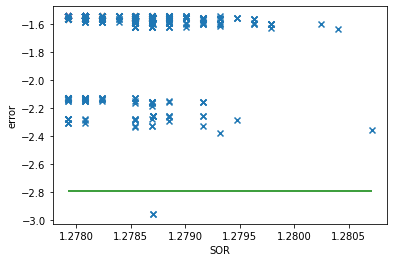

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(sor_sum,np.log10(errors), marker='x')
ax.hlines(np.log10(0.0016), min(sor_sum), max(sor_sum), color='green')
ax.set_xlabel('SOR')
ax.set_ylabel('error')
#ax.set_zlabel('error')

In [22]:
from functools import reduce
sor_sort_indices = np.argsort(-abs(taper_sor_op.coeff_vec))
sor_sort = [taper_sor_op[int(i)] for i in sor_sort_indices if ~np.all(taper_sor_op[int(i)].X_block==0)]
sor_sort = reduce(lambda x,y:x+y, sor_sort[:50])

In [26]:
basis = StabilizerOp({'ZZIIIIZZ':1, 'IIZZIIII':1, 'IIIIIIZZ':1})
print(cheat.weighted_objective(basis, aux_operator=sor_sort))
projected = cheat.project_onto_subspace(basis)
nrg = get_ground_state(projected.to_sparse_matrix)[0]
nrg-true_gs

(0.09550212065911254+0j)


0.00484973210740236

In [ ]:
for comb in range(100):
    Z_block = np.random.randint(0,2,(N, taper_mol_op.n_qubits))
    basis_symp = np.hstack([np.zeros_like(Z_block), Z_block])
    try:
        basis = StabilizerOp(basis_symp, np.ones(N))
        print(cheat.weighted_objective(basis, aux_operator=sor_sort))
        projected = cheat.project_onto_subspace(basis)
        nrg = get_ground_state(projected.to_sparse_matrix)[0]
        print(nrg-true_gs)
        print()
    except:
        pass

0j
0.028658056056727332

0j
0.028658056056443115

(0.03425120772877682+0j)
0j
0.02865651906593314

(0.03425120772877682+0j)
0.028656519065677344

0j
(0.048438522497694356+0j)
0.007443753467711645

0j
0.02864887723669085

(0.03425120772877682+0j)
0.028658056056571013

0j
0.028658056056883652

0j
(0.048438522497694356+0j)
0.026447769114668063

(0.03425120772877682+0j)
0.0074373756981742645

(0.05932483200683727+0j)
0.00693409163159231

(0.048438522497694356+0j)
(0.03425120772877682+0j)
0.028658056056485748

0j
0.028656519065179964

(0.03425120772877682+0j)
(0.03425120772877682+0j)
(0.03425120772877682+0j)
0.02569296775219243

(0.04844344999895261+0j)
(0.03425120772877682+0j)
(0.03425120772877682+0j)
0.02569296672152177

(0.03425120772877682+0j)
0.02865805605649996

(0.03425120772877682+0j)
0.007443814995738762

0j
0.028658056056613646

(0.048438522497694356+0j)
0.02788847876772138

(0.03425120772877682+0j)
(0.059328855362975295+0j)
0.025692967752249274

0j
0.02865651906593314

0j
0.02865

In [ ]:
bases,err = zip(*samples)

In [ ]:
for op,e,s in sorted(list(zip(bases, err, sor_sum)), key=lambda x:-x[2]):
    print(e)
    print(op)
    print(s)
    print()

In [ ]:
list(zip(X, Y))

In [ ]:
projected = cheat.project_onto_subspace(basis)
nrg = get_ground_state(projected.to_sparse_matrix)[0]
print(basis)
print(nrg-true_gs)

In [ ]:
taper_mol_op.commutes_termwise(basis)

In [ ]:
print(len(list(combinations(range(2**10), r=3))))
len([a for a in list(combinations(range(2**10), r=3)) if
    check_independent(bin_to_basis(a))])

In [ ]:
def check_independent(matrix):
    reduced = gf2_gaus_elim(matrix)
    return ~np.any(np.all(reduced==0, axis=1))

def bin_to_basis(basis_indices):
    rows = []
    for index in list(basis_indices):
        binary = format(int(index), f'010b')
        row = np.array([int(i) for i in binary], dtype=int)
        rows.append(row)
    basis_symp = np.vstack(rows)
    return basis_symp
    
        
bin_to_basis([1,2,4])

In [ ]:
bin_set = list(product([0,1], repeat=10))[1:]
np.random.random_sample(bin_set)

In [ ]:
def func(basis_index):
    basis_index = np.round(basis_index)
    print(basis_index)
    rows = []
    for index in list(basis_index):
        binary = format(int(index), f'010b')
        row = np.array([int(i) for i in binary], dtype=int)
        rows.append(row)
    basis_symp = np.vstack(rows)
    basis = StabilizerOp(basis_symp, np.ones(basis_symp.shape[0]))
    return -cheat.commuting_objective(basis)

from scipy.optimize import minimize

minimize(func, x0=np.array([3,30,18]), method='powell', options={'maxiter':100})

In [ ]:
np.triu(mat)

In [ ]:


def bases(N):
    single_op = list(product([0,1], repeat=8))
    bases = [np.array(comb) for comb in combinations(single_op, r=N) if 
            (np.all(np.einsum('ij->i',np.array(comb))!=0) and
             np.all(np.einsum('ij->j',np.array(comb))!=0))]
    return bases

N=2
errors = []
counter = 0
for basis_symp in bases(N):
    basis_symp = np.hstack([np.zeros_like(basis_symp), basis_symp])
    try:
        basis = StabilizerOp(basis_symp, np.ones(N, dtype=int))
        #print(basis)
        projected = cheat.project_onto_subspace(basis)
        nrg = get_ground_state(projected.to_sparse_matrix)[0]
        errors.append([basis, nrg-true_gs])
        print(counter)
    except:
        print('no', counter)
    counter+=1

In [ ]:
from matplotlib import pyplot as plt
sort_errors = sorted(errors, key=lambda x:x[1])
print(sort_errors[0])
chem_acc = [basis for basis, error in sort_errors if error<0.0016]
X1,X2,Y=[],[],[]
for basis, error in sort_errors:
    Y.append(error)
    #print(basis)
    ss = (np.sum(np.square(taper_mol_op.coeff_vec[np.all(taper_mol_op.commutes_termwise(basis), axis=1)])))
    nc = (np.count_nonzero(np.all(taper_mol_op.commutes_termwise(basis), axis=1)))
    
    X1.append(ss)
    X2.append(nc/ss)
    #print()

plt.scatter(X1, np.log10(Y))
plt.hlines(np.log10(0.0016), np.min(X1), np.max(X1), color='green')

In [ ]:
for row in list(zip(X, Y)):
    print(row)

In [ ]:
ref_state = qtap.taper_reference_state(hf_state)
cs_mol = CS_VQE(taper_mol_op, ref_state=ref_state, target_sqp='Z')
cs_mol.noncontextual_energy

In [ ]:
print(cs_mol.contextual_operator.to_dictionary)

In [ ]:
from itertools import combinations

for stab_indices in combinations([0,1,2,3,4], r=2):
    stab_indices = list(stab_indices)
    proj_ham = cs_mol.contextual_subspace_projection(stabilizer_indices=stab_indices)
    #print(proj_ham)
    nrg = get_ground_state(proj_ham.to_sparse_matrix)[0]
    print(nrg, nrg-true_gs)

In [ ]:
from symred.utils import to_indep_set

symmetry = cs_mol.decompose_noncontextual()['symmetry'].copy()
clique_0 = cs_mol.decompose_noncontextual()['clique_0']
C0 = clique_0[6]
for Ci in clique_0:
    symmetry+=C0*Ci
clique_1 = cs_mol.decompose_noncontextual()['clique_1']
C1 = clique_1[5]
for Ci in clique_1:
    symmetry+=C1*Ci

clique_operator = C0 + C1
symmetry_generators = PauliwordOp(
    dict(to_indep_set({op:[None] for op in symmetry.to_dictionary.keys()})[0])
)
basis = clique_operator+symmetry_generators
print(basis)

In [ ]:
from itertools import product, combinations
from symred.symplectic_form import StabilizerOp

def optimal():
    values = []
    for stab_indices in combinations([1,2,3,4], r=3):
        stab_indices = list(stab_indices)
        proj_ham = cs_mol.contextual_subspace_projection(stabilizer_indices=stab_indices)
        #print(proj_ham)
        nrg = get_ground_state(proj_ham.to_sparse_matrix)[0]
        values.append([stab_indices, nrg-true_gs])
    return sorted(values, key=lambda x:x[1])[0]

single_op = list(product([0,1], repeat=4))
bases = [np.array([a,b,c,d]) for a,b,c,d in combinations(single_op, r=4) if 
            (np.all(np.einsum('ij->i',np.array([a,b,c,d]))!=0) and
             np.all(np.einsum('ij->j',np.array([a,b,c,d]))!=0))]

cs_vqe_errors=[]
for mat in bases:
    mat = np.hstack([mat[:,:1], np.zeros_like(mat[:,:1]), mat[:,1:]])
    #print(mat)
    try:
        basis = StabilizerOp(np.hstack([np.zeros_like(mat), mat]), np.ones(4))
        basis+=StabilizerOp({'IXIII':1,'IZIII':1})
        basis = StabilizerOp(basis.to_dictionary)
        basis.coeff_vec = np.ones(6, dtype=int)
        cs_mol.update_basis(basis)
        stab_indices, energy = optimal()
        cs_vqe_errors.append([basis, stab_indices, energy])
    except:
        pass

In [ ]:
X=[]
Y=[]
for op,sind,energy in sorted(cs_vqe_errors, key=lambda x:x[2]):
    #print(energy)
    #print(sind)
    #print(op)
    Y.append(energy)
    X.append(np.count_nonzero(np.all(cs_mol.contextual_operator.commutes_termwise(op)[:,sind],axis=1)))
    #print()

from matplotlib import pyplot as plt

plt.scatter(X,Y)

In [ ]:
basis = PauliwordOp({
    'ZIZZZ':1, 
    'ZIZIZ':1, 
    'ZIZZI':1, 
    'IIZZZ':1,
    'ZXZZI':1,
    'IZIZZ':1
})
cs_mol.update_basis(basis)
cs_mol.noncontextual_energy

In [ ]:
print(cs_mol.symmetry_generators)
print()
print(cs_mol.clique_operator)
print()
print(cs_mol.rotated_stabilizers)

In [ ]:
print(cs_mol.symmetry_generators)
print()
print(cs_mol.clique_operator)
cs_mol.noncontextual_energy

In [ ]:
C0 = cs_mol.clique_representatives[0]
C1 = cs_mol.clique_representatives[1]

rot = (C0*C1).multiply_by_constant(-1j)
angle = np.arctan(C0.coeff_vec/C1.coeff_vec)
#if you wish to rotate onto +1 eigenstate:
if abs(C1.coeff_vec+np.cos(angle)) < 1e-15:
    angle += np.pi
print((cs_mol.clique_representatives._rotate_by_single_Pword(rot, angle)).cleanup_zeros())

In [ ]:
p=1.00001
r_vec = np.array([np.sqrt(1/p), np.sqrt((p-1)/p)])
nu_vec = np.array([-1,1,1,1])

r_indices = cs_mol.noncontextual_reconstruction[:,:cs_mol.n_cliques]
G_indices = cs_mol.noncontextual_reconstruction[:,cs_mol.n_cliques:]

def noncontextual_objective_function(nu_vec, r_vec):
    """
    """
    G_prod = (-1)**np.count_nonzero(np.logical_and(G_indices==1, nu_vec == -1), axis=1)
    r_part = np.sum(r_indices*r_vec, axis=1)
    r_part[np.where(r_part==0)]=1
    return np.sum(cs_mol.noncontextual_operator.coeff_vec*G_prod*r_part).real

def convex_problem(theta):
    nu_vec = np.array([-1,1,1,1])
    r_vec = np.array([np.sin(theta), np.cos(theta)]).T
    return noncontextual_objective_function(nu_vec, r_vec)

noncontextual_objective_function(nu_vec, r_vec)

In [ ]:
theta=1
np.array([np.sin(theta), np.cos(theta)])

In [ ]:
from scipy.optimize import minimize, minimize_scalar

opt_out = minimize_scalar(convex_problem)
print(opt_out)
theta = opt_out['x']
noncontextual_energy = opt_out['fun']
theta, noncontextual_energy

In [ ]:
# order the basis so clique terms appear at the beginning
basis = cs_mol.noncontextual_symmetry_generators
basis_order = np.lexsort(basis.adjacency_matrix)
basis = PauliwordOp(basis.symp_matrix[basis_order],np.ones(basis.n_terms))
n_cliques = np.count_nonzero(~np.all(basis.adjacency_matrix, axis=1))
# note the first two columns will never both be 1... definition of noncontextual set!
# where the 1 appears determines which clique the term is in
print(basis.adjacency_matrix)
reconstruction = cs_mol.noncontextual_operator.basis_reconstruction(basis)
mask_non_universal, clique_index = np.where(reconstruction[:,0:n_cliques])
mask_universal = np.where(np.all(reconstruction[:,0:n_cliques]==0, axis=1)) 

decomposed = {}
univ_symp = cs_mol.noncontextual_operator.symp_matrix[mask_universal]
univ_coef = cs_mol.noncontextual_operator.coeff_vec[mask_universal]
decomposed['symmetry'] = PauliwordOp(univ_symp, univ_coef)

for i in np.unique(clique_index):
    mask_clique = clique_index==i
    Ci_symp = cs_mol.noncontextual_operator.symp_matrix[mask_non_universal][mask_clique]
    Ci_coef = cs_mol.noncontextual_operator.coeff_vec[mask_non_universal][mask_clique]
    decomposed[f'clique_{i}'] = PauliwordOp(Ci_symp, Ci_coef)

print(decomposed['clique_1'])

In [ ]:
print(decomposed['clique_0'])

In [ ]:
symmetry = cs_mol.decompose_noncontextual['symmetry'].copy()

clique_0 = cs_mol.decompose_noncontextual['clique_0']
C0 = clique_0[0]
for Ci in clique_0:
    symmetry+=C0*Ci

clique_1 = cs_mol.decompose_noncontextual['clique_1']
C1 = clique_1[0]
for Ci in clique_1:
    symmetry+=C1*Ci
    
print(symmetry)

In [ ]:
from symred.utils import to_indep_set

In [ ]:
print(cs_mol.noncontextual_symmetry_generators)

In [ ]:
print(QubitTapering(cs_mol.noncontextual_operator).symmetry_generators)

In [ ]:
from symred.symplectic_form import StabilizerOp
def symmetry_generators(op):
    """ Find an independent basis for the input operator symmetry
    """
    # swap order of XZ blocks in symplectic matrix to ZX
    ZX_symp = np.hstack([op.Z_block, op.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)

    return StabilizerOp(kernel, np.ones(kernel.shape[0]))

print(symmetry_generators(cs_mol.decompose_noncontextual['universal']))

In [ ]:
S3_projection(symmetry_generators(cs_mol.decompose_noncontextual['universal']))

In [ ]:
basis = QubitTapering(cs_mol.decompose_noncontextual['universal']).symmetry_generators
print(basis)

In [ ]:
cs_mol.noncontextual_operator.basis_reconstruction(basis)

In [ ]:
def J_term(sqp, N):
    q_pos = list(range(N))
    make_sqp = list(zip(q_pos[:-1], q_pos[1:]))
    out = []
    for i,j in make_sqp:
        blank = list('I'*N)
        blank[i],blank[j]=sqp,sqp
        out.append(''.join(blank))
    return out

def h_terms(N):
    make_Z = list(range(N))
    out = []
    for i in make_Z:
        blank = list('I'*N)
        blank[i]='Z'
        out.append(''.join(blank))
    return out

N=8
terms=[]
for sqp in ['X', 'Y', 'Z']:
    terms+=J_term(sqp, N)
terms+=h_terms(N)


heisenberg = {op:1 for op in terms}
heisenberg_op = PauliwordOp(heisenberg)
qtap = QubitTapering(heisenberg_op)
print(qtap.symmetry_generators)

In [ ]:
print(get_ground_state(heisenberg_op.to_sparse_matrix)[0])
project_op = qtap.taper_it(sector=[-1])
print(get_ground_state(project_op.to_sparse_matrix)[0])

In [ ]:
class CS_VQE(S3_projection):
    pass

In [ ]:
def commute(x,y):
    assert len(x)==len(y), print(x,y)
    s = 1
    for i in range(len(x)):
        if x[i]!='I' and y[i]!='I' and x[i]!=y[i]:
            s = s*(-1)
    if s==1:
        return 1
    else:
        return 0

def contextualQ_ham(ham,verbose=False):
    S = list(ham.keys())
    # Store T all elements of S that anticommute with at least one other element in S (takes O(|S|**2) time).                                                                        
    T=[]
    Z=[] # complement of T                                                                                                                                                           
    for i in range(len(S)):
        if any(not commute(S[i],S[j]) for j in range(len(S))):
            T.append(S[i])
        else:
            Z.append(S[i])
    # Search in T for triples in which exactly one pair anticommutes; if any exist, S is contextual.                                                                                 
    for i in range(len(T)): # WLOG, i indexes the operator that commutes with both others.                                                                                           
        for j in range(len(T)):
            for k in range(j,len(T)): # Ordering of j, k does not matter.                                                                                                            
                if i!=j and i!=k and commute(T[i],T[j]) and commute(T[i],T[k]) and not commute(T[j],T[k]):
                    return True
    if verbose:
        return False,Z,T
    else:
        return False
op_dict = {'II':1,'XY':1,'XX':1, 'ZZ':1, 'YX':1, 'ZX':1}
print(contextualQ_ham(op_dict))

test = PauliwordOp(op_dict)
adj_mat = np.array(test.adjacency_matrix, dtype=int)
adj_mat
#where_commutes_universally = ~np.all(adj_mat, axis=1)
#remove_universally_commuting = adj_mat[where_commutes_universally,:][:,where_commutes_universally]
#remove_universally_commuting

In [ ]:
def condense_array(in_array):
    # order lexicographically and take difference between adjacent rows
    term_ordering = np.lexsort(in_array.T)
    diff_adjacent = np.diff(in_array[term_ordering], axis=0)
    # the unique terms are those which are non-zero
    mask_unique_terms = np.append(True, ~np.all(diff_adjacent==0, axis=1))
    # drop duplicate terms
    out_array = in_array[term_ordering,:][:,term_ordering][mask_unique_terms,:][:,mask_unique_terms]
    return out_array

In [ ]:
def is_contextual(op):
    adj_mat = np.array(op.adjacency_matrix, dtype=int)
    condensed = condense_array(adj_mat)
    print(condensed)
    return ~np.all(condensed[::-1].diagonal())

is_contextual(test)

In [ ]:
mol_op_dict = mol_op.to_dictionary
%timeit contextualQ_ham(mol_op_dict)

In [ ]:
from datetime import datetime
from datetime import timedelta

def contextualQ(S,verbose=False):
    # Store T all elements of S that anticommute with at least one other element in S (takes O(|S|**2) time).
    T=[]
    Z=[] # complement of T
    for i in range(len(S)):
        if any(not commute(S[i],S[j]) for j in range(len(S))):
            T.append(S[i])
        else:
            Z.append(S[i])
    # Search in T for triples in which exactly one pair anticommutes; if any exist, S is contextual.
    for i in range(len(T)): # WLOG, i indexes the operator that commutes with both others.
        for j in range(len(T)):
            for k in range(j,len(T)): # Ordering of j, k does not matter.
                if i!=j and i!=k and commute(T[i],T[j]) and commute(T[i],T[k]) and not commute(T[j],T[k]):
                    if verbose:
                        return [True,None,None]
                    else:
                        return True
    if verbose:
        return [False,Z,T]
    else:
        return False
    
def greedy_dfs(ham,cutoff,criterion='weight'):
    
    weight = {k:abs(ham[k]) for k in ham.keys()}
    possibilities = [k for k, v in sorted(weight.items(), key=lambda item: -item[1])] # sort in decreasing order of weight
    
    best_guesses = [[]]
    stack = [[[],0]]
    start_time = datetime.now()
    delta = timedelta(seconds=cutoff)
    
    i = 0
    
    while datetime.now()-start_time < delta and stack:
        
        while i < len(possibilities):
#             print(i)
            next_set = stack[-1][0]+[possibilities[i]]
#             print(next_set)
#             iscontextual = contextualQ(next_set)
#             print('  ',iscontextual,'\n')
            if not contextualQ(next_set):
                stack.append([next_set,i+1])
            i += 1
        
        if criterion == 'weight':
            new_weight = sum([abs(ham[p]) for p in stack[-1][0]])
            old_weight = sum([abs(ham[p]) for p in best_guesses[-1]])
            if new_weight > old_weight:
                best_guesses.append(stack[-1][0])
                # print(len(stack[-1][0]))
                # print(stack[-1][0],'\n')
            
        if criterion == 'size' and len(stack[-1][0]) > len(best_guesses[-1]):
            best_guesses.append(stack[-1][0])
            # print(len(stack[-1][0]))
            # print(stack[-1][0],'\n')
            
        top = stack.pop()
        i = top[1]
    
    return best_guesses

In [ ]:
print(greedy_dfs(taper_mol_op.to_dictionary, cutoff=1)[-1])

In [ ]:
from quantumtools.Hamiltonian import QubitHamiltonian, HamiltonianGraph

In [ ]:
HamiltonianGraph(QubitHamiltonian(taper_mol_op.to_dictionary))

In [ ]:
terms, coeffs = zip(*taper_mol_op.to_dictionary.items())
terms, coeffs = list(terms), list(coeffs)
graph = HamiltonianGraph(terms, coeffs)
g_dict = graph.clique_cover('AC', 'largest_first')
largest_AC_set = sorted(g_dict.items(), key=lambda x:-x[1].n_terms)[0][1]

In [ ]:
print(largest_AC_set)

In [ ]:
from symred.symplectic_form import PauliwordOp
from symred.S3_projection import CS_VQE
op1 = PauliwordOp({'XX':1, 'YY':1j})
op2 = PauliwordOp({'XY':1, 'YY':1j})
print((op1-op2).cleanup_zeros())

In [ ]:
s=slice(0,5,2)

In [ ]:
test = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(test)

In [ ]:
test[:,[2,0]]